# Imports

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Loading and cleaning data

In [2]:
# 1) Load data
DATA_PATH = "MarketFarePredictionData.csv"
df = pd.read_csv(DATA_PATH)

# Linear regression model

In [6]:
# 2) Feature engineering
df["fare_per_mile"] = df["Average_Fare"] / df["NonStopMiles"]
df["distance_log"] = np.log1p(df["NonStopMiles"])
df["fare_log"] = np.log1p(df["Average_Fare"]) # Log transormation of target for stability
df["pax_ratio"] = df["CarrierPax"] / df["Pax"]
df["is_roundtrip"] = df["RoundTrip"].astype(int)
df["has_multiple_airports"] = df["Multi_Airport"].astype(int)
df["nonstop_flag"] = df["Non_Stop"].astype(int)

# 4) Assign feature types
numeric_features = [
    "NonStopMiles", "MktCoupons", "Pax", "CarrierPax", "MktMilesFlown",
    "Market_share", "Market_HHI", "LCC_Comp", 
    "fare_per_mile", "distance_log", "pax_ratio"
]
categorical_features = [
    "Carrier", "OriginAirportID", "DestAirportID",
    "is_roundtrip", "has_multiple_airports", "nonstop_flag"
]

X = df[numeric_features + categorical_features]
y = df["fare_log"]

# 5) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 6) Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

pipe = Pipeline([
    ("pre", preprocessor),
    ("lr", LinearRegression())
])

# 7) Fit model
pipe.fit(X_train, y_train)

Test MSE: 782.63
Test MAE: 15.20
Test R2 : 0.854


# Model evaluation

Test MSE: 782.63
Test MAE: 15.20
Test R2 : 0.854


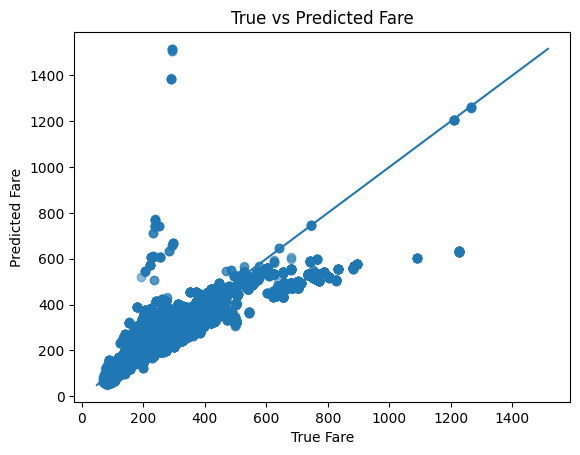

In [8]:
y_pred_log = pipe.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R2 : {r2:.3f}")

plt.figure()
plt.scatter(y_true, y_pred, alpha=0.5)
lims = [
    min(y_true.min(), y_pred.min()),
    max(y_true.max(), y_pred.max())
]
plt.plot(lims, lims)
plt.xlabel("True Fare")
plt.ylabel("Predicted Fare")
plt.title("True vs Predicted Fare")
plt.show()